In [31]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import collections
import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import PIL
import scipy
import sklearn
from sklearn.decomposition import PCA
import sys

import pytoolsAL as ptAL
from pytoolsAL.neuropixels import RainierData
# import dualprobe as dupr
# import multipredictor as mpred

ModuleNotFoundError: No module named 'RainierData'

In [29]:
print(dir(ptAL.neuropixels))

['Path', 'RainierData', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_bin_neurons_positions', '_find_max_channels', '_plot_drift_map', 'computePR', 'copy_server_data', 'curve_fit', 'display', 'mpl', 'np', 'os', 'plt', 'ptAL', 'rpqc', 'scipy', 'shutil', 'sys', 'vis_resp_ttest', 'warnings']


In [2]:
import slidingRP

In [3]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [9]:
#personal
plt.style.use(r'C:\GitHub\steinmetzlab\ALpres.mplstyle')

OSError: 'C:\\GitHub\\steinmetzlab\\ALpres.mplstyle' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

#### experiment key
- 2: data folder
- 3: seven powers, three spots
- 4: RF mapping
- 5: bilateral inhib: three powers, two spots (left/right V1)
- 6 and 7 are errors
- 8: different durations, one power, sine wave vs step inhib

In [36]:
expdir = Path(r'Y:\Subjects\AB_0032\2024-08-14\1')
expStartStop = np.load(expdir / 'expStartStopTimes.npy')
gx = np.squeeze(np.load(expdir / 'galvoXPositions.npy'))
gy = np.squeeze(np.load(expdir / 'galvoYPositions.npy'))
laserAmp = np.squeeze(np.load(expdir / 'laserPowers.npy'))
laserOnTimes = np.squeeze(np.load(expdir / 'laserOnTimes.npy'))
laserOffTimes = np.squeeze(np.load(expdir / 'laserOffTimes.npy'))
tl_sync = np.squeeze(np.load(expdir / 'tl_sync.npy'))
p_sync = np.squeeze(np.load(expdir / 'p0_g0_t0.imec0_sync.npy'))

tl_to_p = scipy.interpolate.interp1d(tl_sync, p_sync)

server = Path(r'Y:\Subjects')
rd = RainierData(server,'AB_0032','2024-08-14','1')

In [5]:
def getParams(ca_en, en):
    """
    finds the right indeces of experiment characteristics using expStartStop
    """
    this_en = en - ca_en - 1
    start, stop = expStartStop[this_en]
    e1 = np.squeeze(np.argwhere(laserOnTimes > start))
    e2 = np.squeeze(np.argwhere(laserOnTimes < stop))

    these_entries = np.intersect1d(e1, e2)
    exp = collections.namedtuple('experiment', ['galvoX', 'galvoY', 'laserAmp', 'laserOn', 'laserOff'])
    thisExp = exp(gx[these_entries], gy[these_entries], laserAmp[these_entries], 
                  tl_to_p(laserOnTimes[these_entries]), tl_to_p(laserOffTimes[these_entries]))
    return thisExp

In [6]:
pdir = Path(r'Y:\Subjects\AB_0032\2024-08-14\1\p0_g0_t0.imec0')
st = np.squeeze(np.load(pdir / 'spike_times.npy')) #
sc = np.squeeze(np.load(pdir / 'spike_clusters.npy'))

In [39]:
neurons, spks = rd.separate_spikes(st, sc)
bins = np.arange(st[0]/3e4, st[-1]/3e4, 1) # ms bins
spk_mat = ptAL.neuropixels.binner(neurons, spks, bins)
spk_mat_z = scipy.stats.zscore(spk_mat, axis=1)
# spk_mat = spk_mat.T / (np.median(spk_mat, axis=1)+0.01)
# spk_mat = spk_mat.T


TypeError: RainierData.separate_spikes() takes 1 positional argument but 3 were given

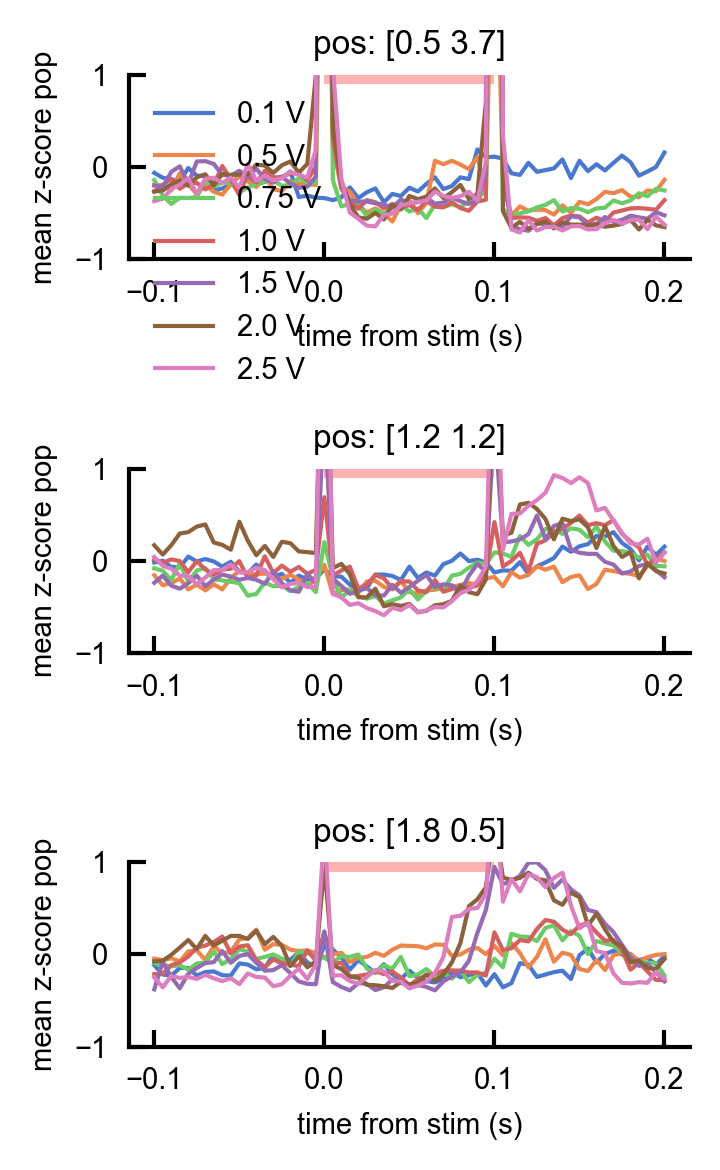

In [96]:
expPowers = getParams(ca_en=2, en=3)
powers = np.unique(expPowers.laserAmp)
positions = np.unique(np.vstack((expPowers.galvoX, expPowers.galvoY)), axis=1).T
window = np.arange(-0.1, 0.2, 0.005) # trial bins
f = plt.figure(figsize=(2.5, 4), dpi=300)
gs = mpl.gridspec.GridSpec(3, 1)
pos_labels = ['left SS', 'left V1', 'left ACA']
pop_mean = scipy.stats.zscore(np.mean(spk_mat, axis=0))

for iP, pos in enumerate(positions):
    pos_x, pos_y = pos
    match_x = np.squeeze(np.argwhere(expPowers.galvoX == pos_x))
    match_y = np.squeeze(np.argwhere(expPowers.galvoY == pos_y))
    match = np.intersect1d(match_x, match_y)

    ax = plt.subplot(gs[iP])
    plt.title(f'pos: {pos}')
    plt.axvspan(0, 0.1, ymin=0.95, ymax=1, color='red', lw=0, alpha=0.3)
    plt.xlabel('time from stim (s)')
    plt.ylabel('mean z-score pop')
    plt.ylim(-1, 1)

    for pow in powers:
        match_pow = np.squeeze(np.argwhere(expPowers.laserAmp == pow))
        match_both = np.intersect1d(match, match_pow)
        these_times = expPowers.laserOn[match_both]
        tr_times = [window+i for i in these_times]

        t_to_spks = scipy.interpolate.interp1d(bins[:-1], pop_mean, kind='previous')
        tr_spks = t_to_spks(tr_times)
        plt.plot(window, np.mean(tr_spks, axis=0), label=f'{pow} V')

    if iP == 0:
        plt.legend()

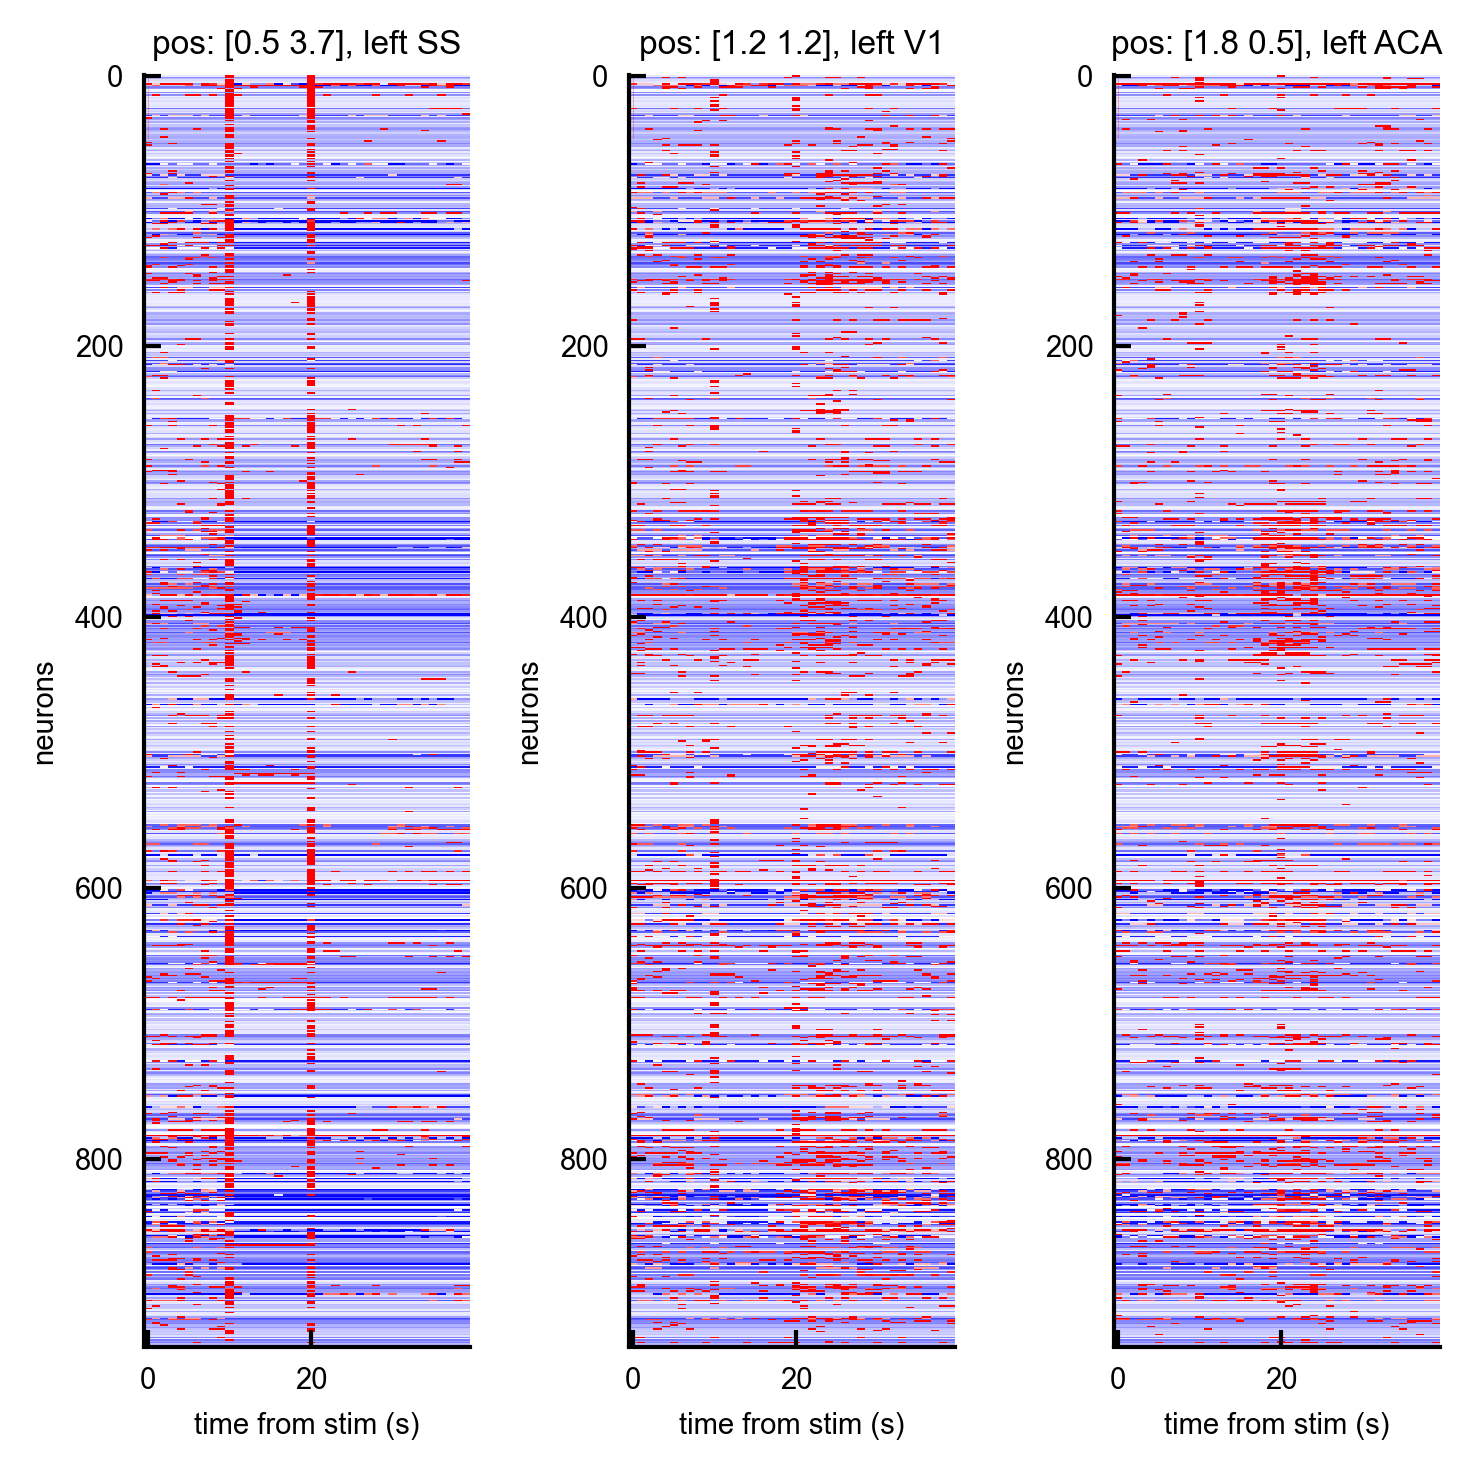

In [97]:
expPowers = getParams(1, 2)
powers = np.unique(expPowers.laserAmp)
positions = np.unique(np.vstack((expPowers.galvoX, expPowers.galvoY)), axis=1).T
window = np.arange(-0.1, 0.3, 0.01) # trial bins
f = plt.figure(figsize=(5, 5), dpi=300)
gs = mpl.gridspec.GridSpec(1, 3)
pos_labels = ['left SS', 'left V1', 'left ACA']

for iP, pos in enumerate(positions):
    pos_x, pos_y = pos
    match_x = np.squeeze(np.argwhere(expPowers.galvoX == pos_x))
    match_y = np.squeeze(np.argwhere(expPowers.galvoY == pos_y))
    match = np.intersect1d(match_x, match_y)

    ax = plt.subplot(gs[iP])
    plt.title(f'pos: {pos}, {pos_labels[iP]}')
    plt.axvspan(0, 0.1, ymin=0.95, ymax=1, color='red', lw=0, alpha=0.3)
    plt.xlabel('time from stim (s)')
    plt.ylabel('neurons')

    pow = powers[-1]
    match_pow = np.squeeze(np.argwhere(expPowers.laserAmp == pow))
    match_both = np.intersect1d(match, match_pow)
    these_times = expPowers.laserOn[match_both]
    tr_times = [window+i for i in these_times]

    t_to_spks = scipy.interpolate.interp1d(bins[:-1], spk_mat_z, axis=1, kind='previous')
    tr_spks = t_to_spks(tr_times)
    plot_spks = np.mean(tr_spks, axis=1)
    plt.imshow(plot_spks, clim=[-0.2, 0.2], cmap='bwr', aspect='auto')